# Support Vector Machine
### Peter Ma | Dec 31st 2025

In Logistic Regression, we just wanted any line that separated the data. SVMs are greedy: they want the best line. By "best," we mean the line that creates the widest possible "street" (margin) between the two classes.We define our linear separator just like before:$$f(x) = W^T X + \beta$$

Unlike Logistic Regression where $y \in \{0, 1\}$, in SVMs it makes the math way easier if we use signed labels:$$y \in \{-1, +1\}$$

We want our model to be confident.If $y_i = +1$, we want $W^T X_i + \beta \ge 1$.If $y_i = -1$, we want $W^T X_i + \beta \le -1$.We can combine these into one constraint:$$y_i (W^T X_i + \beta) \ge 1$$If this condition holds, the point is correctly classified and is "off the street" (outside the margin).

### The Margin
Let us define what this margin is...

We define three parallel hyperplanes (lines in 2D): **Positive Hyperplane**: $w^T x + b = 1$ (This touches the nearest positive points). **Negative Hyperplane**: $w^T x + b = -1$ (This touches the nearest negative points). 

Decision Boundary: $w^T x + b = 0$ (The centerline).

*The Margin is the perpendicular distance between the Positive and Negative hyperplanes.*

We can get this margin. Let's pick two points that lie exactly on the edge of the street:Let $x_+$ be a point on the Positive Hyperplane.Let $x_-$ be the point on the Negative Hyperplane that is directly "underneath" $x_+$ (perpendicular to the boundary).Since $x_-$ is directly across from $x_+$, the vector connecting them $(x_+ - x_-)$ is perfectly parallel to the normal vector $w$.Therefore, the distance (margin width) is just the projection of the vector $(x_+ - x_-)$ onto the unit normal vector.$$\text{Width} = (x_+ - x_-) \cdot \frac{w}{||w||}$$(Note: $\frac{w}{||w||}$ is the unit direction vector).3. The AlgebraLet's expand that dot product:$$\text{Width} = \frac{w^T(x_+ - x_-)}{||w||}$$$$\text{Width} = \frac{w^T x_+ - w^T x_-}{||w||}$$Now, use the equations of the planes we defined in Step 1 to substitute values for $w^T x$:From $w^T x_+ + b = 1$, we know $w^T x_+ = 1 - b$.From $w^T x_- + b = -1$, we know $w^T x_- = -1 - b$.Substitute these back into the width equation:$$\text{Width} = \frac{(1 - b) - (-1 - b)}{||w||}$$The $b$'s cancel out:$$\text{Width} = \frac{1 - b + 1 + b}{||w||}$$$$\text{Width} = \frac{2}{||w||}$$


## Optimization

We want to do two things simultaneously: 

**Maximize the Margin:** Geometrically, the width of the margin is $\frac{2}{||W||}$. To maximize width, we minimize $||W||^2$. 

**Minimize Errors:** If a point violates the margin (it's inside the street or on the wrong side), we pay a penalty.This leads us to the Hinge Loss:$$\mathcal{L}_{hinge} = \max(0, 1 - y_i(W^T X_i + \beta))$$Our total loss function (the Primal Objective) is a sum of the Regularizer (maximize margin) and the Hinge Loss (minimize error):$$\mathcal{L} = \underbrace{\frac{1}{2} ||W||^2}_{\text{Maximize Margin}} + C \underbrace{\sum_{i=1}^N \max(0, 1 - y_i(W^T X_i + \beta))}_{\text{Minimize Violations}}$$($C$ is a hyperparameter. High $C$ means "Hard Margin" (intolerant of errors). Low $C$ means "Soft Margin" (wider street, accepts some mistakes).)

## Gradients
The Hinge Loss has a sharp "kink" at 1, so strictly speaking, it's not differentiable everywhere. But we don't care; we use the sub-gradient:If $1 - y_i(W^T X_i + \beta) \le 0$ (Correct & Safe):$$\nabla_W \mathcal{L} = W$$(Just decay the weights slightly)If $1 - y_i(W^T X_i + \beta) > 0$ (Wrong or Unsafe):$$\nabla_W \mathcal{L} = W - C y_i X_i$$(Decay weights + push the boundary away from the data point)

Final Weights: [ 0.01390198 -0.24345854 -0.6626574 ]


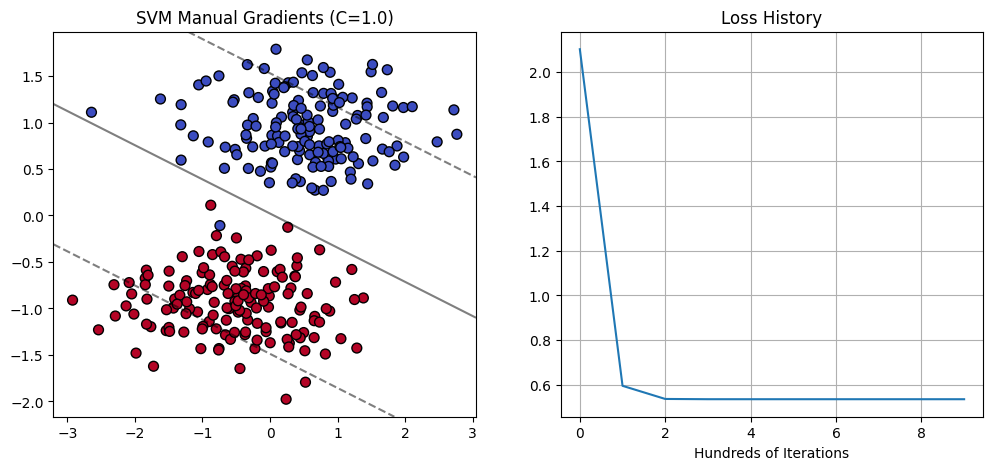

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# 1. Load Data
X, y = make_blobs(n_samples=300, centers=2, random_state=6, cluster_std=1.2)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Map labels to {-1, 1}
y = jnp.array(y)
y = jnp.where(y == 0, -1, 1)[:, None]
X = jnp.array(X)

# 2. Bias Trick
ones = jnp.ones((X.shape[0], 1))
X_aug = jnp.hstack((ones, X))

# 3. Initialization
key = jax.random.PRNGKey(42)
W = jax.random.normal(key, (X_aug.shape[1], 1))

# Loss function (Used only for logging purposes now)
def loss_fn(W, X, y, C):
    # Don't regularize the bias (index 0)
    reg_loss = 0.5 * jnp.sum(W[1:] ** 2)
    # Hinge: mean(max(0, 1 - y(XW)))
    distances = 1 - y * (X @ W)
    hinge_loss = jnp.mean(jnp.maximum(0, distances))
    return reg_loss + C * hinge_loss

# MANUAL GRADIENT UPDATE
@jax.jit
def update_step(W, X, y, learning_rate, C):
    N = X.shape[0]
    
    # 1. Identify Violations (The Mask)
    # distance = 1 - y_i(w^T x_i)
    # If distance > 0, the point is inside the margin -> It contributes to gradient
    scores = X @ W
    margins = 1 - (y * scores)
    
    # mask is 1.0 where we have violations, 0.0 elsewhere
    mask = (margins > 0).astype(jnp.float32)
    
    # 2. Compute Hinge Gradient
    # For a single point: grad = -y * x
    # Vectorized sum: -X.T @ (mask * y)
    # We divide by N because the loss used jnp.mean()
    grad_hinge = -(X.T @ (mask * y)) / N
    
    # 3. Compute Regularization Gradient
    # Derivative of 0.5*||w||^2 is just w.
    # BUT we must set bias gradient to 0 (we don't regularize intercept)
    grad_reg = W
    grad_reg = grad_reg.at[0].set(0.0)
    
    # 4. Total Gradient
    total_grad = grad_reg + C * grad_hinge
    
    return W - learning_rate * total_grad

# Training Loop
learning_rate = 0.01
epochs = 1000
C_param = 1.0
loss_history = []

for i in range(epochs):
    W = update_step(W, X_aug, y, learning_rate, C_param)
    if i % 100 == 0:
        loss_history.append(loss_fn(W, X_aug, y, C_param))

print(f"Final Weights: {W.flatten()}")

# 5. Plotting
plt.figure(figsize=(12, 5))

# Plot Decision Boundary
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='coolwarm', s=50, edgecolors='k')

# Meshgrid for contours
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = jnp.linspace(xlim[0], xlim[1], 30)
yy = jnp.linspace(ylim[0], ylim[1], 30)
YY, XX = jnp.meshgrid(yy, xx)
xy = jnp.vstack([XX.ravel(), YY.ravel()]).T
xy_aug = jnp.hstack((jnp.ones((xy.shape[0], 1)), xy))
Z = (xy_aug @ W).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.title(f"SVM Manual Gradients (C={C_param})")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Hundreds of Iterations")
plt.grid(True)

plt.show()

## Kernel Connection
The Kernel Trick is a brilliant mathematical "hack" in machine learning. It allows a linear classifier (like the SVM we just built) to solve non-linear problems (like separating a red circle inside a blue ring) essentially for free. And from a theroy of deep learning persepctive offers many nice explanations to how more complex models work. So lets understand this.


### The Problem
Linearity is really Rigid.  The SVM code we just wrote finds a straight line (or hyperplane) $W^T X + b = 0$. If your data looks like a "bullseye" (concentric circles), no straight line can ever separate them. You would get ~50% accuracy.

### The Solution
Feature Mapping ($\phi$) If we can't separate the data in 2D, we can project it into a higher dimension where it is linearly separable! Imagine 2D data points $(x_1, x_2)$. Let's map them to 3D using a function $\phi(x)$:$$\phi([x_1, x_2]) = [x_1, x_2, x_1^2 + x_2^2]$$ We added a "height" axis based on distance from the origin.Points near the center (small radius) stay low.Points in the outer ring (large radius) float up high. Now, you can just slide a flat sheet (a linear plane) between the low points and the high points. When you project that flat sheet back down to 2D, it looks like a circle.

### The "Trick" 
However, mapping data to higher dimensions can be computationally expensive. Mapping 2D to 3D is fine. Mapping 100 features to 100,000 features is slow. Mapping to infinite dimensions is impossible.... This is where the Kernel Trick comes in. If you derive the Dual Form of the SVM optimization problem (using Lagrange Multipliers),there is a cool property: *the optimization never uses the raw data points $X$.* It only ever uses the dot products between pairs of points:$$x_i \cdot x_j$$So, if we want to work in the high-dimensional space $\phi(x)$, we only need to know:$$\phi(x_i) \cdot \phi(x_j)$$

### Kernel Function 

We define a Kernel Function $K(x_i, x_j)$ that computes this high-dimensional dot product directly from the low-dimensional data, without ever actually calculating the coordinates of $\phi(x)$.$$K(x_i, x_j) = \phi(x_i) \cdot \phi(x_j)$$ 
#### Example
The Infinite Dimension (RBF Kernel)The most popular kernel is the Radial Basis Function (RBF):$$K(x_i, x_j) = e^{-\gamma ||x_i - x_j||^2}$$This function returns a scalar between 0 and 1 (1 if points are identical, 0 if far apart).

Mathematically, the RBF kernel corresponds to a feature map $\phi(x)$ into an infinite-dimensional space! If you tried to actually compute the coordinates $\phi(x)$, you would need infinite memory and infinite time.But computing $e^{-\gamma ||x_i - x_j||^2}$ is superfast. So, the Kernel Trick allows us to fit a linear hyperplane in an infinite-dimensional universe, effectively giving us a decision boundary of infinite complexity in our original space, all with the computational cost of a simple dot product.

### Whats the catch?
The catch is the "Curse of N"

Firstly, to solve the Dual Form, you need to compute the kernel function for every pair of data points.This creates the Gram Matrix (or Kernel Matrix), which is an $N \times N$ grid.If $N = 1,000$: You need a $1,000 \times 1,000$ matrix (1 million entries). Easy. If $N = 1,000,000$: You need a $10^{12}$ entry matrix.Assuming float32 (4 bytes), that is 4 Terabytes of RAM.You simply cannot store the kernel matrix for large datasets. You have to compute it on the fly, which makes training incredibly slow.

Secondly, inference speeds. In a Kernel SVM, there is no $W$. The "weight" is actually just a linear combination of the Support Vectors.1 To make a prediction, you have to calculate the kernel distance between your new point and every single Support Vector you found during training

Thirdly, it overfits "Too easily": Because you are working in infinite dimensions (with RBF kernel), you can technically separate any dataset perfectly.


## Demo

Final Bias: -1.1039990186691284


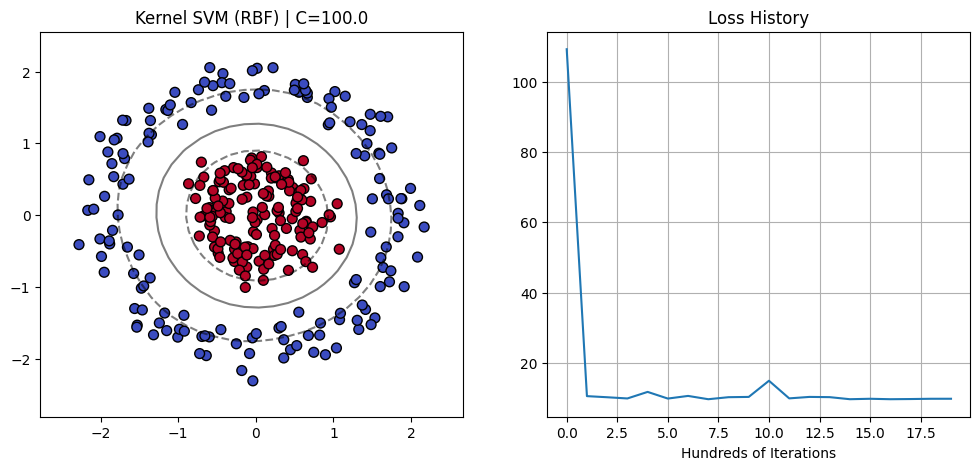

In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

# 1. Load Data (Non-linear dataset this time!)
#    We use make_circles, which is impossible for a linear SVM.
X, y = make_circles(n_samples=300, factor=0.3, noise=0.1, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Map labels to {-1, 1}
y = jnp.array(y)
y = jnp.where(y == 0, -1, 1)[:, None]
X = jnp.array(X)

# --- THE KERNEL TRICK SETUP ---
# We define the RBF Kernel: exp(-gamma * ||x - y||^2)
def rbf_kernel(x1, x2, gamma=1.0):
    return jnp.exp(-gamma * jnp.sum((x1 - x2) ** 2))

# Use vmap to compute the pairwise kernel matrix (N x N)
# This creates the "Gram Matrix" where K[i, j] is similarity between data[i] and data[j]
gamma_param = 0.5
K_matrix = jax.vmap(lambda x1: jax.vmap(lambda x2: rbf_kernel(x1, x2, gamma_param))(X))(X)

# 2. Initialization
#    INSTEAD OF W (features x 1), WE LEARN BETA (samples x 1)
#    According to Representer Theorem: w = sum(beta_i * phi(x_i))
key = jax.random.PRNGKey(42)
Beta = jax.random.normal(key, (X.shape[0], 1)) * 0.1
Bias = 0.0  # Keep bias separate for Kernel methods

# Loss function
# Note: The input here is the Kernel Matrix 'K', not the features 'X'
def loss_fn(Beta, Bias, K, y, C):
    # Model prediction: f(x) = K * Beta + Bias
    logits = (K @ Beta) + Bias
    
    # Hinge Loss: mean(max(0, 1 - y * logits))
    hinge_loss = jnp.mean(jnp.maximum(0, 1 - y * logits))
    
    # Regularization: 0.5 * Beta.T @ K @ Beta
    # (This is the kernelized equivalent of 0.5 * ||w||^2)
    reg_loss = 0.5 * (Beta.T @ (K @ Beta))[0, 0]
    
    return reg_loss + C * hinge_loss

# MANUAL GRADIENT UPDATE
@jax.jit
def update_step(Beta, Bias, K, y, learning_rate, C):
    N = K.shape[0]
    
    # 1. Forward Pass
    logits = (K @ Beta) + Bias
    
    # 2. Identify Violations (The Mask)
    margins = 1 - (y * logits)
    mask = (margins > 0).astype(jnp.float32)
    
    # 3. Compute Gradients
    # Gradient of Hinge w.r.t Beta
    # Chain rule: dLoss/dBeta = dLoss/dLogits * dLogits/dBeta
    # dLogits/dBeta = K
    # dLoss/dLogits = -y * mask
    grad_hinge_beta = -(K.T @ (mask * y)) / N
    
    # Gradient of Hinge w.r.t Bias
    grad_hinge_bias = -jnp.sum(mask * y) / N
    
    # Gradient of Regularization w.r.t Beta
    # d(0.5 * B.T @ K @ B)/dB = K @ B
    grad_reg_beta = K @ Beta
    
    # 4. Total Gradients
    total_grad_beta = grad_reg_beta + C * grad_hinge_beta
    total_grad_bias = C * grad_hinge_bias # No regularization on bias
    
    # 5. Update
    new_Beta = Beta - learning_rate * total_grad_beta
    new_Bias = Bias - learning_rate * total_grad_bias
    
    return new_Beta, new_Bias

# Training Loop

# Lower the learning rate to prevent "jumping" too fast
learning_rate = 0.001  # Changed from 0.01

# Increase C so the model cares MORE about accuracy than complexity
C_param = 100.0        # Changed from 10.0

# learning_rate = 0.01
epochs = 2000
# C_param = 10.0 # Higher C for non-linear often helps
loss_history = []

for i in range(epochs):
    Beta, Bias = update_step(Beta, Bias, K_matrix, y, learning_rate, C_param)
    if i % 100 == 0:
        loss_history.append(loss_fn(Beta, Bias, K_matrix, y, C_param))

print(f"Final Bias: {Bias}")

# --- PLOTTING (Tricky part: we need to compute Kernel distance for meshgrid points) ---
plt.figure(figsize=(12, 5))

# Plot Data
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='coolwarm', s=50, edgecolors='k')

# Generate Meshgrid
ax = plt.gca()
xx = jnp.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 30)
yy = jnp.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 30)
YY, XX = jnp.meshgrid(yy, xx)
grid_points = jnp.vstack([XX.ravel(), YY.ravel()]).T

# COMPUTE KERNEL BETWEEN GRID POINTS AND TRAINING POINTS
# We need K(X_train, X_grid)
# shape: (N_train, N_grid)
K_grid = jax.vmap(lambda x_train: jax.vmap(lambda x_g: rbf_kernel(x_train, x_g, gamma_param))(grid_points))(X)

# Prediction = (Beta.T @ K_grid) + Bias
# shape: (1, N_grid)
Z = (Beta.T @ K_grid) + Bias
Z = Z.reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.title(f"Kernel SVM (RBF) | C={C_param}")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Hundreds of Iterations")
plt.grid(True)

plt.show()